# Классификация и линейная регрессия со scikit-learn

План:

1. Наивная байесовская классификация.
1. Алгоритм к-ближайших соседей.

## Часть 1. Наивная байесовская классификация документов

### Описание метода

Описание метода представлено здесь:

* РУС: [Наивный баейсовский классификатор](http://datascientist.one/naive-bayes/)
* РУС: [6 простых шагов для освоения наивного байесовского алгоритма](http://datareview.info/article/6-prostyih-shagov-dlya-osvoeniya-naivnogo-bayesovskogo-algoritma-s-primerom-koda-na-python/)
* ENG: [Naive Bayes Document Classification in Python](https://towardsdatascience.com/naive-bayes-document-classification-in-python-e33ff50f937e)
* ENG: [A practical explanation of a Naive Bayes classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/)

### Выбор датасета

Для самостоятельной работы предлагается выбрать один из датасетов

* [Amazon Alexa Reviews](https://www.kaggle.com/sid321axn/amazon-alexa-reviews#amazon_alexa.tsv)

* [Wine Reviews](https://www.kaggle.com/zynicide/wine-reviews)


В данном блокноте датасет взят [Women's E-Commerce Clothing Reviews](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews).

In [ ]:
!pip install kaggle

В ячейке ниже загружаем kaggle.json для вашей среды выполнения Colab, полученный на https://www.kaggle.com/.



In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


Создаем папку, в которую выгрузим датасет:

In [ ]:
!cd /content/
!mkdir reviews-dataset
!cd /content/reviews-dataset

mkdir: cannot create directory ‘reviews-dataset’: File exists


In [ ]:
!unzip /content/reviews-dataset/wine-reviews.zip -d /content/reviews-dataset

Archive:  /content/reviews-dataset/wine-reviews.zip
replace /content/reviews-dataset/winemag-data-130k-v2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Загружаем датасет:

In [ ]:
!kaggle datasets download -d zynicide/wine-reviews -p /content/reviews-dataset

wine-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


### Получение DataFrame из датасета 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 'Магическая' функция matplotlib
%matplotlib inline 

# Есть пять предустановленная тем Seaborn: darkgrid, whitegrid, dark, white, 
# и ticks. Каждый из них подходит для различных приложений и личных предпочтений.
sns.set(style="ticks")

import warnings
warnings.filterwarnings('ignore')

In [ ]:
CURENT_DIR = '/content/reviews-dataset'

In [ ]:
# Загрузить набор данных
data = pd.read_csv(CURENT_DIR+'/winemag-data_first150k.csv', sep="," )

# Распечать первые 5 строк фрейма данных
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


### Выбор интересующих колонок

 Нас интересует текст, категория:

In [ ]:
df = data[['description','points']]
df.head()

,description,points
0,This tremendous 100% varietal wine hails from ...,96
1,"Ripe aromas of fig, blackberry and cassis are ...",96
2,Mac Watson honors the memory of a wine once ma...,96
3,"This spent 20 months in 30% new French oak, an...",96
4,"This is the top wine from La Bégude, named aft...",95


### Первичный осмотр выбранного датасета

In [ ]:
df.dtypes

description    object
points          int64
dtype: object

In [ ]:
df['description'] = df['description'].astype(str)

In [ ]:
for col in df.columns:
    print('{} - {}'.format(col, df[df[col].isnull()].shape[0]))

description - 0
points - 0


Датасет приведен в порядок, можно продолжать!

### Разделение на тестовую и обучающую выборку

При построении предсказательных моделей исходные данные обычно разбиваются на обучающую ("training set") и контрольную ("test set", "validation set") выборки. Обучающая выборка используется собственно для "обучения" той или иной модели, т.е. для построения математических отношений между некоторой переменной-откликом и предикторами, тогда как контрольная (= "проверочная", "экзаменационная") выборка служит для получения оценки прогнозных свойств модели на новых данных, т.е. данных, которые не были использованы для обучения модели. Как правило, обучающая выборка составляет 75-80% от объема исходных данных, хотя каких-то строгих правил в этом отношении не существует. Рассмотрим, как можно выполнить подобное разбиение исходных данных на обучающую и контрольную выборки стандартными средствами R и при помощи пакета caret.

Подробнее см. [здесь](https://r-analytics.blogspot.com/2015/08/blog-post_31.html).

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['description'], df['points'], random_state=1)

In [ ]:
print('X_train: {}  y_train: {}'.format(X_train.shape, y_train.shape))
print('X_test: {}  y_test: {}'.format(X_test.shape, y_test.shape))

X_train: (113197,)  y_train: (113197,)
X_test: (37733,)  y_test: (37733,)


### Работа с текстом



Наивный байесовский классификатор должен уметь вычислять, сколько раз каждое слово появляется в каждом документе и сколько раз оно появляется в каждой категории. Чтобы сделать это возможным, данные должны выглядеть примерно так:

```
[0, 1, 0, …]
[1, 1, 1, …]
[0, 2, 0, …]
```

Каждая строка представляет документ, а каждый столбец-слово.

Одна из первых концепций обрабтки естественных языков [Bag-of-Words](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%88%D0%BE%D0%BA_%D1%81%D0%BB%D0%BE%D0%B2) — это статистический анализ, анализирующий количественное вхождение слов в документах. Не смотря на то, что подход сформирован весьма давно, он отлично подходит для первичной обработки текстов и быстрого прототипирования.

Модуль [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) в `sklearn` как раз подзволяет сконвертировать набор текстов в матрицу токенов, находящихся в тексте. Также имеется много полезных настроек, например можно задать минимальное количество необходимое для появления токена в матрице и даже получить статистику по n-граммам. Следует учитывать, что `CountVectorizer` по умолчанию сам производит токенизацию и выкидывает слова с длиной меньшей чем два.

См. подробнее [здесь](http://zabaykin.ru/?p=463).

#### Пример работы CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
     'This is the first document.',
     'This document is the second document.',
     'And this is the third one.',
     'Is this the first document?',
]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

In [ ]:
vectorizer.get_feature_names_out()

In [ ]:
print(X.toarray())

[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


In [ ]:
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X2 = vectorizer2.fit_transform(corpus)

In [ ]:
vectorizer2.get_feature_names_out()

array(['and this', 'document is', 'first document', 'is the', 'is this',
       'second document', 'the first', 'the second', 'the third',
       'third one', 'this document', 'this is', 'this the'], dtype=object)

In [ ]:
print(X2.toarray())

[[0 0 1 1 0 0 1 0 0 0 0 1 0]
 [0 1 0 1 0 1 0 1 0 0 1 0 0]
 [1 0 0 1 0 0 0 0 1 1 0 1 0]
 [0 0 1 0 1 0 1 0 0 0 0 0 1]]


#### Применение CountVectorizer для датасета

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(strip_accents='unicode', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', lowercase=True, stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [ ]:
len(cv.get_feature_names_out())

27716

In [ ]:
len(X_test_cv.toarray()[0])

27716

Мы можем использовать аргументы `strip_accents`, `token_pattern`, `lowercase` и `stopwords` для исключения "стоп-слов", чисел, артиклей и других вещей, которые не полезны для прогнозирования категорий из наших подсчетов. Дополнительные сведения см. в [документации](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB).

Если вы хотите просмотреть данные и исследовать количество слов, вы можете создать фрейм данных для количества слов со следующим кодом:

In [ ]:
word_freq_df = pd.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names())
word_freq_df.head()

Функция [`sum()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sum.html) будет суммировать по колонкам:

In [ ]:
word_freq_df.sum()

In [ ]:
top_words_df = pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False)
top_words_df.head()

,0
love,713
echo,616
great,524
t,456
alexa,437


### Мучаем Байса



Теперь мы готовы подогнать [Мультиномиальную наивную байесовскую классификаторную](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) модель к нашим обучающим данным и использовать ее для прогнозирования меток тестовых данных:

In [ ]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_cv, y_train)
predictions = naive_bayes.predict(X_test_cv)

### Проверяем результаты


Давайте посмотрим, как модель работает с тестовыми данными:

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print('Accuracy score: ', accuracy_score(y_test, predictions)) 
print('Precision score: ', precision_score(y_test, predictions.astype(int), average='macro'))
print('Recall score: ', recall_score(y_test, predictions.astype(int), average='macro'))

Accuracy score:  0.3106299525614184
Precision score:  0.3962629461624185
Recall score:  0.1857499537939722


[`Accuracy score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) (доля правильных ответов алгоритма) - это оценка точности классификации. В классификации с несколькими метками эта функция вычисляет точность подмножества: набор меток, предсказанный для выборки, должен точно соответствовать соответствующему набору меток в `y_true`.

[`Precision score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) (точность) - это отношение  `tp / (tp + fp)`, где `tp` - количество истинных срабатываний и `fp` количество ложных срабатываний. Точность — это интуитивно способность классификатора не маркировать отрицательный образец как положительный. Лучшее значение равно `1`, а худшее значение равно `0`.


[`Recall score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) (полонота) - это отношение `tp / (tp + fn)`, где `tp` - количество истинных положительных результатов и `fn` количество ложных отрицательных результатов. Под отзывом понимается интуитивно способность классификатора находить все положительные образцы.

Подробнее про метрики [здесь](https://habr.com/ru/company/ods/blog/328372/).



Чтобы понять эти оценки, `hotmap` помогает увидеть разбивку с помощью [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html):

Text(80.90000000000006, 0.5, 'predicted label')

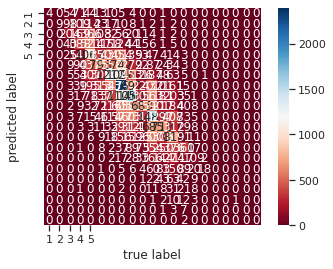

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', fmt="d",
xticklabels=np.arange(1,6).astype(str), yticklabels=np.arange(1,6).astype(str))
plt.xlabel('true label')
plt.ylabel('predicted label')

### Пробуем на своих примерах

In [ ]:
X_check = np.array(["I don't like this thing, it sucks.", 
                    "I hate this thing. I don not like her. I do not know what to do. This thing is not worth the money.",
                    "I love these clothes",
                    "The dress is too small for me.",
                    "It was huge, shapeless."])
X_check_cv = cv.transform(X_check)
predictions_check = naive_bayes.predict(X_check_cv)
predictions_check

array([5, 5, 5, 5, 5])